<a href="https://colab.research.google.com/github/shvm2012/Natural-Language-Processing-essentials/blob/master/Sentiment_classification_word_embeddings_KERAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imdb Sentiment Analysis 


###  IMDB sentiment classification using deep learning and word embeddings in KERAS. Aim is to maximize F1 score on the test data
#### useful imports

In [0]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook
import os
import re
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize



from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras import layers
from keras.layers import Dense, GRU, Flatten, LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras import optimizers

Using TensorFlow backend.


In [0]:
nltk.download('punkt')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
!pip install pymagnitude   # library to manipulate word embedding vectors
from pymagnitude import *

     |████████████████████████████████| 5.4MB 46.3MB/s 
  Created wheel for pymagnitude: filename=pymagnitude-0.1.120-cp36-cp36m-linux_x86_64.whl size=135918205 sha256=3931843822eb59ad7e16dae3bfbb4c6180d73b31ae657c3c2392dd84e831c46d
  Stored in directory: /root/.cache/pip/wheels/a2/c7/98/cb48b9db35f8d1a7827b764dc36c5515179dc116448a47c8a1
Successfully built pymagnitude


In [0]:
# Downloading glove (100 dimensional word embedding vectors)
!wget http://magnitude.plasticity.ai/glove/light/glove.6B.100d.magnitude

--2019-09-01 02:44:15--  http://magnitude.plasticity.ai/glove/light/glove.6B.100d.magnitude
Resolving magnitude.plasticity.ai (magnitude.plasticity.ai)... 52.216.139.82
Connecting to magnitude.plasticity.ai (magnitude.plasticity.ai)|52.216.139.82|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 193871872 (185M) [binary/octet-stream]
Saving to: ‘glove.6B.100d.magnitude’

glove.6B.100d.magni 100%[===================>] 184.89M  20.1MB/s    in 10s     

2019-09-01 02:44:26 (18.1 MB/s) - ‘glove.6B.100d.magnitude’ saved [193871872/193871872]



#### downloading and extracting required dataset

In [0]:
![ ! -d data ] && mkdir data/
![ -f data/aclImdb_v1.tar.gz ] && echo "Skip Download"
![ ! -f data/aclImdb_v1.tar.gz ] && wget -N https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz -P data/

--2019-09-01 02:44:32--  https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘data/aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  21.4MB/s    in 5.2s    

2019-09-01 02:44:38 (15.5 MB/s) - ‘data/aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [0]:
![ -d data/aclImdb/ ] && echo "Data already extracted"
![ ! -d data/aclImdb/ ] && tar -xzf data/aclImdb_v1.tar.gz -C data/

In [0]:
data_folder = 'data/aclImdb/'   

#### loading data file names as list of strings

In [0]:
rp = os.path.join(data_folder, 'train/pos')
train_positive = [os.path.join(rp, f) for f in os.listdir(rp)]

rp = os.path.join(data_folder, 'train/neg')
train_negative = [os.path.join(rp, f) for f in os.listdir(rp)]

rp = os.path.join(data_folder, 'test/pos')
test_positive = [os.path.join(rp, f) for f in os.listdir(rp)]

rp = os.path.join(data_folder, 'test/neg')
test_negative = [os.path.join(rp, f) for f in os.listdir(rp)]

In [0]:
len(train_positive)

12500

## Data cleaning and preprocessing

In [0]:
remove_pun = RegexpTokenizer(r'\w+') # punctuation removal
stop_words = set(stopwords.words('english')) # stop-word removal

In [0]:
def clean_sentence(sent):
  
  ''' function to clean a given sentence/review by removing punctuation and stopwords and returns cleaned sentence '''
  
  good_words =[]
  
  for w in remove_pun.tokenize(sent.lower()):
    if w not in stop_words: 
      good_words.append(w)
            
  new_sentence = ' '.join(word for word in good_words)
  return new_sentence


In [0]:
# sent = "My name is shivam yadav, ** I like to solve rubik's  ## # cube ,,, ; ; Heloooooo World : :) !!" ## testing above function
# clean_sentence(sent)

In [0]:
n_train = 12500    # all train sentence to be loaded for training
n_test = 12500      # all test sentence to be loaded for testing
re_html_cleaner = re.compile(r"<.*?>") 

In [0]:
train_data = []
y_train = []

for _fname in tqdm_notebook(train_positive[:n_train], desc="Loading +ve training samples: "):
    with open(_fname,encoding="utf8") as f:
        text = f.read().strip()
        text = re_html_cleaner.sub(" ", text)
        wseq = clean_sentence(text)
        train_data.append(wseq)
        y_train.append(1)
        
for _fname in tqdm_notebook(train_negative[:n_train], desc="Loading -ve training samples: "):
    with open(_fname,encoding="utf8") as f:
        text = f.read().strip()
        text = re_html_cleaner.sub(" ", text)
        wseq = clean_sentence(text)
        train_data.append(wseq)
        y_train.append(0)

In [0]:
len(train_data)

25000

In [0]:
## first review in training sample (cleaned sample) and its corresponding sentiment (1 : positive, 0: negative)
print(train_data[0])
print("")
print("sentiment: ",y_train[0])

give four reasons see movie 1 four best filmmakers contemporary mexican cinema 2 four good stories related big scheme 3 surprisingly good cast 4 bitter reflexion biggest trouble country many others possible spoilers alejandro gamboa opens movie good story comedic mood authority practicing extortion regular people still expecting appreciated efforts antonio serrano gets dramatic second piece story heir italian neorealism peter wolf like anecdote third story one seems independent series even context carlos carrera tells us story man wrong place wrong moment recent lynching tlahuac tradition awful matter state mexico story updated end fernando sariñana returns dark humor grand finale puts together characters past sequences one better comedy pieces ever filmed reprising center scene one previous films todo el poder sariñana gives final lesson theme way give us scene steals movie anna ciochetti making brief striptease movie ended get bittersweet feeling looked good movie maybe enjoyed painf

In [0]:
test_data = []
y_test = []
for _fname in tqdm_notebook(test_positive[:n_test], desc="Loading +ve test samples: "):
    with open(_fname,encoding="utf8") as f:
        text = f.read().strip()
        text = re_html_cleaner.sub(" ", text)
        wseq = clean_sentence(text)
        test_data.append(wseq)
        y_test.append(1)
        
for _fname in tqdm_notebook(test_negative[:n_test], desc="Loading -ve test samples: "):
    with open(_fname,encoding="utf8") as f:
        text = f.read().strip()
        text = re_html_cleaner.sub(" ", text)
        wseq = clean_sentence(text)
        test_data.append(wseq)
        y_test.append(0)

#### Data preparation

In [0]:
tokenizer = Tokenizer(num_words = 10000) # max 10000 words we are keeping, based on the frequency count
tokenizer.fit_on_texts(train_data)

In [0]:
X_train = tokenizer.texts_to_sequences(train_data) ## each word in each train/test sentence is index numerically
X_test = tokenizer.texts_to_sequences(test_data)

In [0]:
print(train_data[0])
print(X_train[0])

give four reasons see movie 1 four best filmmakers contemporary mexican cinema 2 four good stories related big scheme 3 surprisingly good cast 4 bitter reflexion biggest trouble country many others possible spoilers alejandro gamboa opens movie good story comedic mood authority practicing extortion regular people still expecting appreciated efforts antonio serrano gets dramatic second piece story heir italian neorealism peter wolf like anecdote third story one seems independent series even context carlos carrera tells us story man wrong place wrong moment recent lynching tlahuac tradition awful matter state mexico story updated end fernando sariñana returns dark humor grand finale puts together characters past sequences one better comedy pieces ever filmed reprising center scene one previous films todo el poder sariñana gives final lesson theme way give us scene steals movie anna ciochetti making brief striptease movie ended get bittersweet feeling looked good movie maybe enjoyed painf

In [0]:
# Building vocabulary
vocab_size = len(tokenizer.word_index) + 1  # 1 is added because the indexig of the words start from 1, 
                                            # by adding 1 we preserve index 0, not assigned to any word 
vocab_size

74622

In [0]:
# for example, the index of movie, happy and sad in the vocabulary is :
for word in ['movie','happy', 'sad']:
    print('{}: {}'.format(word, tokenizer.word_index[word]))

movie: 1
happy: 511
sad: 484


In [0]:
maxlen = 100 # maximum length of word sequence for a review

X_train = pad_sequences(X_train, padding='post', maxlen = maxlen) # if any review is less than maxlen we pad it with zeros to make it upto maxlen length
X_test = pad_sequences(X_test, padding='post', maxlen = maxlen)

In [0]:
glove_vectors = Magnitude("glove.6B.100d.magnitude") # loading pretrained word embeddings, each word is represented by a 100 dimensional vector

In [0]:
glove_vectors.query("movie")[:20] ## "movie" word index = 1, looking at first 20 dimension of a movie vector

array([ 0.0616435,  0.0238848,  0.0976617, -0.0830481,  0.0708954,
        0.009839 , -0.1010701, -0.0040909,  0.0264778, -0.0356169,
        0.0232434, -0.0599707, -0.0349433, -0.0143348,  0.0157777,
        0.105734 ,  0.1038726,  0.0768678,  0.1351271,  0.2656806],
      dtype=float32)

In [0]:
vocab_words = [i for i,value in tokenizer.word_index.items()] ## extracting all vocabulary words in increasing order of the index sequence
vocab_words[:5]

['movie', 'film', 'one', 'like', 'good']

In [0]:
## Creating word embedding matrix for our corpus/vocabulary, extracting required word vectors from the pretrained glove_vectors
word_embedding_matrix = np.array(glove_vectors.query(vocab_words))

In [0]:
print(word_embedding_matrix.shape)
print(len(vocab_words))
vocab_size

(74621, 100)
74621


74622

In [0]:
# since our vocabulary starts from zero index so the first row in the word_embedding_matrix should be of null
# the zeroth row is null vector, word "movie" has first index = 1

zero_word_vec = np.zeros(100)

complete_word_embedding_matrix = np.vstack((zero_word_vec,word_embedding_matrix)) 

In [0]:
 ## allmost 100% of our vocabulary is coverd with the pretrained word embeddings from glove
nonzero_elements = np.count_nonzero(np.count_nonzero(complete_word_embedding_matrix, axis=1))
nonzero_elements / vocab_size  

0.9999865991262631

## RNN based Classifier Training and Prediction on test data

In [0]:
import matplotlib.pyplot as plt
def plot_history(history):
    ''' helper function to plot training/testing accuracy and loss with respect to epochs '''
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.xlabel("Epochs")
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.xlabel("Epochs")
    plt.title('Training and validation loss')
    plt.legend()

#### defining DL classification model
##### since there is no class imbalance in the target value ACCURACY on the test set can be good metric to look at for model training. I will calculate the F1 score on the test set using the best accurate model. 

In [0]:
np.random.seed(7)

## These model hyper_parameters such as learning rate,batch size, dropout, number of units are found out by grid_search on
## hyperparameter space in a seperate notebook.

## I am usings our word embedding matrix as pretained weights and the matrix weights will be updated during our model training

model = Sequential()
model.add(layers.Embedding(input_dim = vocab_size, output_dim = 100, weights=[complete_word_embedding_matrix], trainable=True, input_length = 75))
model.add(GRU(128,dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(1, activation='sigmoid'))

optim = optimizers.Adam(lr=0.001)

model.compile(optimizer=optim, loss='binary_crossentropy', metrics = ["accuracy"])
# # model.summary()

W0901 02:45:31.291577 140358331389824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0901 02:45:31.337180 140358331389824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0901 02:45:31.346199 140358331389824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0901 02:45:31.362391 140358331389824 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0901 02:45:31.366197 1403583313

In [0]:
# training our defined model
history = model.fit(X_train, y_train, epochs=5, verbose=1, validation_data=(X_test,y_test), batch_size=64) 

Train on 25000 samples, validate on 25000 samples
Epoch 1/5
25000/25000 [==============================] - 69s 3ms/step - loss: 0.4933 - acc: 0.7562 - val_loss: 0.3590 - val_acc: 0.8476
Epoch 2/5
25000/25000 [==============================] - 64s 3ms/step - loss: 0.3104 - acc: 0.8780 - val_loss: 0.3071 - val_acc: 0.8701
Epoch 3/5
25000/25000 [==============================] - 64s 3ms/step - loss: 0.2330 - acc: 0.9128 - val_loss: 0.3146 - val_acc: 0.8655
Epoch 4/5
25000/25000 [==============================] - 65s 3ms/step - loss: 0.1838 - acc: 0.9334 - val_loss: 0.3423 - val_acc: 0.8604
Epoch 5/5
25000/25000 [==============================] - 64s 3ms/step - loss: 0.1357 - acc: 0.9531 - val_loss: 0.4092 - val_acc: 0.8509


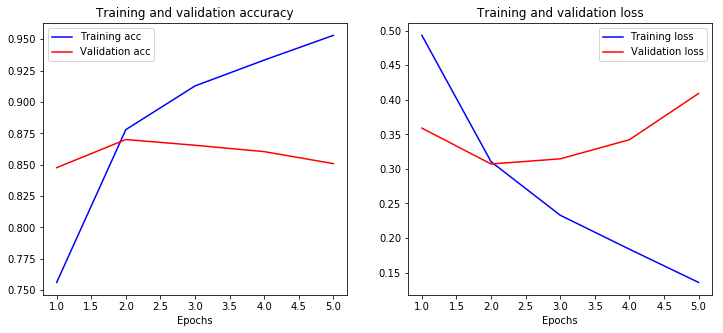

In [0]:
# vizualizing our model performance in each epoch to diagnose overfitting and find out optimal number of epochs for model training.
plot_history(history)

From the plot we can easily see that our model starts overfitting after two epochs.
So we will train our model only for 2 epochs and use this model to predict the test data sentiment.

#### training the model for 2 epochs

In [0]:
np.random.seed(7)
model = Sequential()
model.add(layers.Embedding(input_dim = vocab_size, output_dim = 100, weights=[complete_word_embedding_matrix], trainable=True, input_length = 100))
model.add(GRU(128,dropout=0.3, recurrent_dropout=0.3))
model.add(Dense(1, activation='sigmoid'))
optim = optimizers.Adam(lr=0.001)
model.compile(optimizer=optim, loss='binary_crossentropy', metrics = ["accuracy"])

model.fit(X_train, y_train, epochs=2, verbose=1, validation_data=(X_test,y_test), batch_size=64)

Train on 25000 samples, validate on 25000 samples
Epoch 1/2
 5632/25000 [=====>........................] - ETA: 53s - loss: 0.6742 - acc: 0.5540

#### predicting the class probability on the test dataset

In [0]:
y_pred = model.predict_proba(X_test)

#### changing the class probability into crisp classification to calcualte F1 score on the test dataset. 

#### Probability >= 0.5 : Positive review
#### Probability < 0.5 : Negative review

In [0]:
y_pred_class =  np.where(y_pred>=0.5,1,0)
print("F1 score on test data: ",f1_score(y_test,y_pred_class))

F1 score on test data:  0.8595348069943913
